# Import Libraries

In [1]:
import numpy as np
import pandas as pd

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to stop tf false warning

from keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random


# Prepare Datasets

### Constants

In [2]:
test_valid_split = 0.15
fast_run = 0 # option to "fast run" for debugging/test new features
full_test_set = 0 # not submitting (no need to test on 25k images)

image_size = 128
input_shape = (image_size, image_size, 3)

### Set paths

In [3]:
train_path = "../Dogs_Cats/train/"
test_path = "../Dogs_Cats/test1/"

### Create Training (`train_df`) and Validating (`valid_df`) Dataframes - containing image filenames and labels

In [4]:
# Extract category from image filenames
filenames = os.listdir(train_path)
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

# Create dataframes that will be used in generators 
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

train_df, valid_df = train_test_split(df, test_size=test_valid_split)

if fast_run == 1: 
    train_df = train_df.sample(n=2000).reset_index() 
    valid_df = valid_df.sample(n=100).reset_index()
else:
    train_df = train_df.reset_index()
    valid_df = valid_df.reset_index()

total_train = train_df.shape[0]
total_valid = valid_df.shape[0]

### Create Testing (`test_df`) Dataframe 

In [5]:
test_filenames = os.listdir(test_path)

test_df = pd.DataFrame({
    'filename': test_filenames
})

if full_test_set == 0: 
    test_df = test_df.sample(n=500).reset_index() 

total_test = test_df.shape[0]

### Checks

In [6]:
df['category'].value_counts()

# Both category are equally represented in training set

category
1    12500
0    12500
Name: count, dtype: int64

# Build Model

The model will be based on VGG16 (16 layer CNN, 1000-class classifier) and fine tuned for the purpose of this project (i.e. binary classification) by adding 4 extra trainable layers.

* Epochs: 20 (w/ EarlyStopping callback)
* Batch_size: 16
* Loss: Binary Crossentropy
* Optimizor: Stochastic Gradient Descent (w/ lr=0.0001 & momentum=0.9)

In [7]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.applications import VGG16
from keras.models import Model
from keras.callbacks import EarlyStopping

# Settings
epochs = 20
batch_size = 16

# Load pre-trained VGG16 model
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

# Fix first 15 layers and make 15th layer trainable
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

# Defined the next layers for project purpose (i.e. flatten the output layer to 1 dimension)
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x) # Add a fully connected layer
x = Dropout(0.5)(x) # Add a dropout layer
x = layers.Dense(1, activation='sigmoid')(x) # Sigmoid for classification

# Final model structure
model = Model(pre_trained_model.input, x)

# Define callbacks
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

# Define Generators

### Training Generator (w/ generated images)

In [8]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    train_path,
    x_col='filename',
    y_col='category',
    class_mode='raw',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 21250 validated image filenames.


### Validation Generator

In [9]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    valid_df,
    train_path,
    x_col='filename',
    y_col='category',
    class_mode='raw',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle = False
)

Found 3750 validated image filenames.


### Testing Generator

In [10]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    test_path,
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 500 validated image filenames.


# Train Model

In [11]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_valid//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=[early_stopping_callback])

Epoch 1/20
1328/1328 [==============================] - 2527s 2s/step - loss: 0.3927 - accuracy: 0.8160 - val_loss: 0.2268 - val_accuracy: 0.9038
Epoch 2/20
1328/1328 [==============================] - 2484s 2s/step - loss: 0.2526 - accuracy: 0.8935 - val_loss: 0.1893 - val_accuracy: 0.9223
Epoch 3/20
1328/1328 [==============================] - 3099s 2s/step - loss: 0.2157 - accuracy: 0.9086 - val_loss: 0.1803 - val_accuracy: 0.9265
Epoch 4/20
1328/1328 [==============================] - 3294s 2s/step - loss: 0.1995 - accuracy: 0.9172 - val_loss: 0.1864 - val_accuracy: 0.9183
Epoch 5/20
1328/1328 [==============================] - 2851s 2s/step - loss: 0.1828 - accuracy: 0.9225 - val_loss: 0.1512 - val_accuracy: 0.9396
Epoch 6/20
1328/1328 [==============================] - 3218s 2s/step - loss: 0.1685 - accuracy: 0.9307 - val_loss: 0.1463 - val_accuracy: 0.9434
Epoch 7/20
1328/1328 [==============================] - 3018s 2s/step - loss: 0.1618 - accuracy: 0.9325 - val_loss: 0.1628 -

### Save model with best weights (based on callback)

In [12]:
model.save("../Dogs_Cats/best_model.h5")

### Plot model performance

In [13]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary crossentropy')
    ax1.grid(True)
    ax1.legend(['train', 'val'], loc='best')
    
    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    ax2.legend(['train', 'val'], loc='best')

    plt.show()

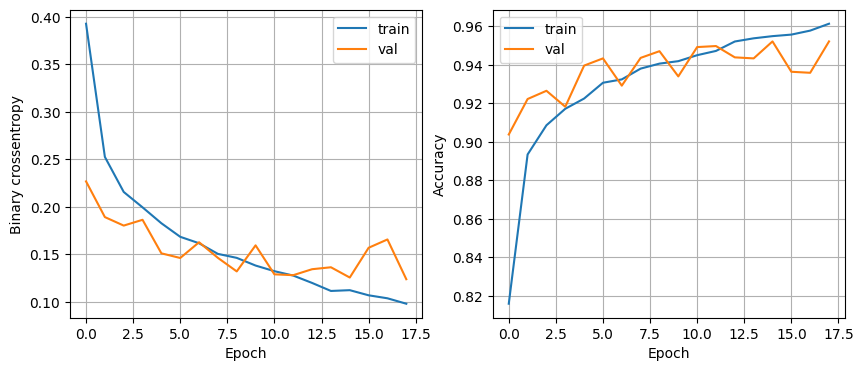

In [14]:
plot_history(history)

### Plot confusion matrix (on validation set)

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusion_matrix_plot(validation_labels, predictions):
    # Can add/remove `normalize='ture' parameter 
    cm = confusion_matrix(validation_labels, predictions, normalize='true')

    # Define the new labels
    labels = ['Cat', 'Dog']

    # Display the confusion matrix
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Plot
    fig, ax = plt.subplots(figsize=(4,4))
    #disp.plot(cmap=plt.cm.Blues)
    cmp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False) # Deactivate default colorbar
    

In [16]:
valid_labels = valid_df['category']

valid_predictions =  model.predict(validation_generator)
threshold = 0.5
valid_predictions = np.where(valid_predictions > threshold, 1,0)

235/235 [==============================] - 296s 1s/step


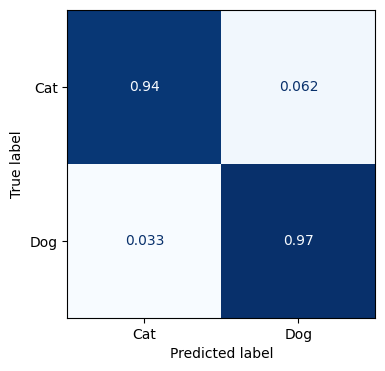

In [17]:
confusion_matrix_plot(valid_labels, valid_predictions)

### Alternatively, print the classification report (on validation set)

In [20]:
from sklearn.metrics import classification_report

print(classification_report(valid_labels, valid_predictions))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1867
           1       0.94      0.97      0.95      1883

    accuracy                           0.95      3750
   macro avg       0.95      0.95      0.95      3750
weighted avg       0.95      0.95      0.95      3750



# Predictions

### Use model on test images

In [18]:
predict = model.predict(test_generator, steps=np.ceil(total_test/batch_size))

threshold = 0.5
test_df['category'] = np.where(predict > threshold, "Dog", "Cat")

32/32 [==============================] - 39s 1s/step


### Plot examples of prediction made by model

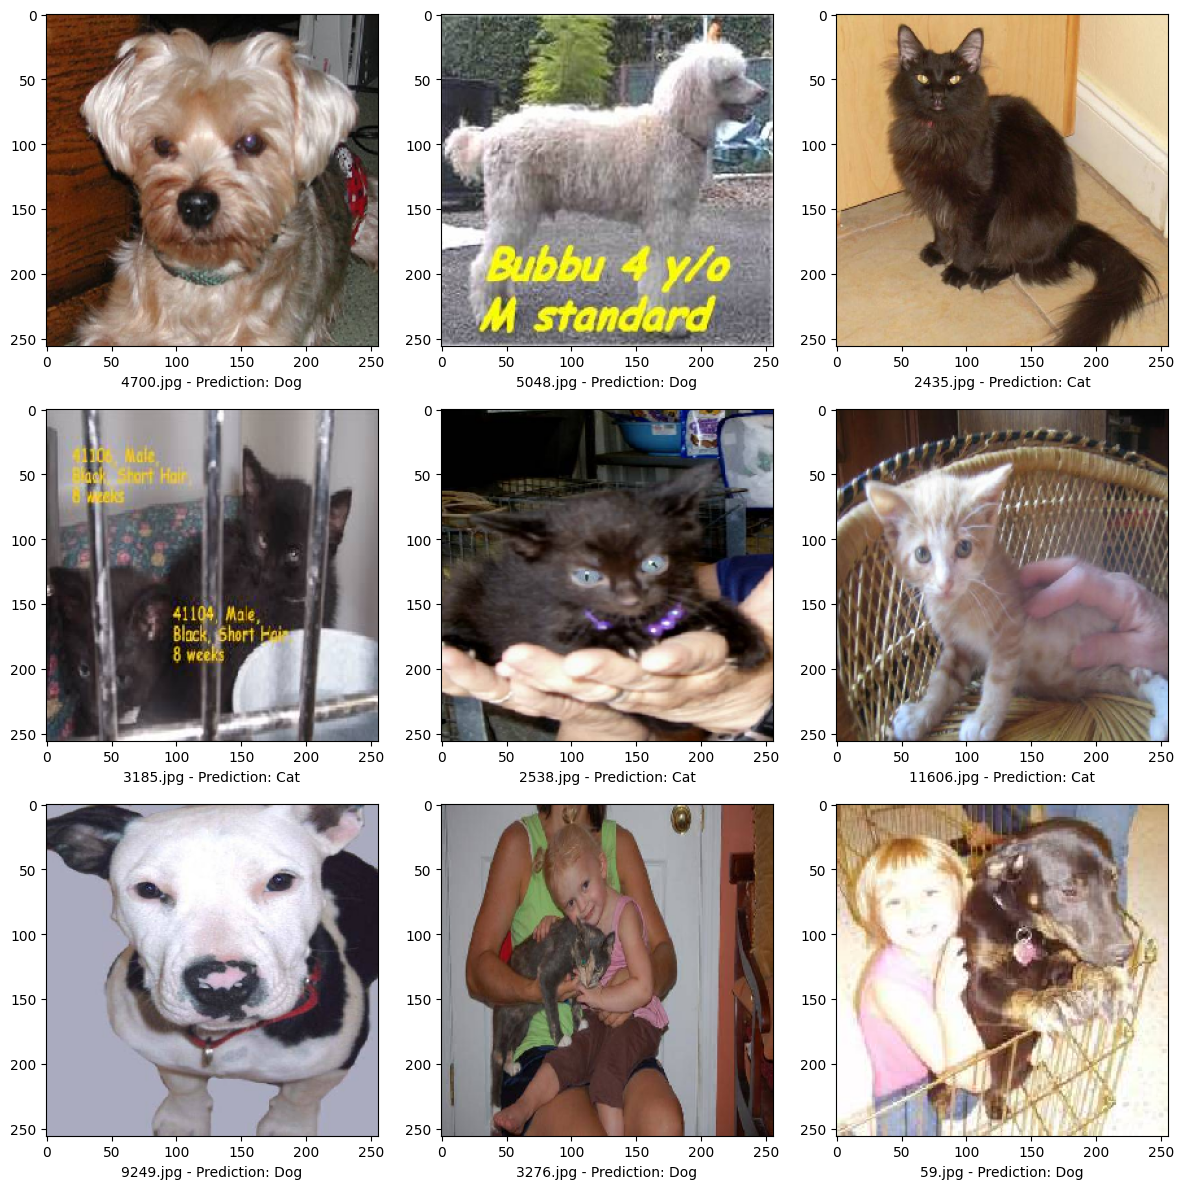

In [21]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(test_path+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + ' - Prediction: ' + "{}".format(category))
plt.tight_layout()
plt.show()